# ResNet50 and New Preprocessing

## Trying ResNet50 with same preprocessing as baseline simple CNN for comparison

In [29]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from fastai import *
from fastai.vision import *
import os
import keras
from keras.layers import Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
from keras import models, optimizers, Sequential, regularizers, layers
from keras.models import load_model, model_from_json, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical
from keras.applications import resnet50
from keras.callbacks import EarlyStopping
from keras.layers import Flatten, Dropout, Reshape, Dense, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
import itertools
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import applications  
from keras import backend as k

np.random.seed(123)

In [30]:
img_width, img_height = 224, 224
img_shape = (img_width, img_height, 3)
img_input = Input(shape=img_shape)
base_model = resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=img_shape)

In [31]:
for i, layer in enumerate(base_model.layers):
    print(i, layer)

0 <keras.engine.input_layer.InputLayer object at 0x7fa4a6f63780>
1 <keras.layers.convolutional.ZeroPadding2D object at 0x7fa4a6ce0630>
2 <keras.layers.convolutional.Conv2D object at 0x7fa4a6ce0128>
3 <keras.layers.normalization.BatchNormalization object at 0x7fa4a6ce0278>
4 <keras.layers.core.Activation object at 0x7fa4a6ce0f28>
5 <keras.layers.convolutional.ZeroPadding2D object at 0x7fa4a6cfd358>
6 <keras.layers.pooling.MaxPooling2D object at 0x7fa4a6c76f60>
7 <keras.layers.convolutional.Conv2D object at 0x7fa4a6c79668>
8 <keras.layers.normalization.BatchNormalization object at 0x7fa4a6b45320>
9 <keras.layers.core.Activation object at 0x7fa4a6b453c8>
10 <keras.layers.convolutional.Conv2D object at 0x7fa4a6b60128>
11 <keras.layers.normalization.BatchNormalization object at 0x7fa4a6b3c048>
12 <keras.layers.core.Activation object at 0x7fa4a6b3cf98>
13 <keras.layers.convolutional.Conv2D object at 0x7fa4a6a7b518>
14 <keras.layers.convolutional.Conv2D object at 0x7fa4a69d4630>
15 <keras.lay

In [32]:
directory = 'data/train_images/'

In [ ]:
images

In [46]:
target_size=(224, 224)
seed = 123
batch_size = 64
epochs = 50
directory = 'data/train_images/'

# set up data generator
train_datagen = ImageDataGenerator(rescale=1./255,
    featurewise_center=True,
#     shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode="nearest",
    zoom_range=0.1,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    rotation_range=45)

# create a set of images to fit the generator on for featurewise_center
fit_images = ImageDataGenerator(rescale=1./255,
#     shear_range=0.2,
    horizontal_flip=True,
    fill_mode = "nearest",
    zoom_range = 0.1,
#     width_shift_range = 0.2,
#     height_shift_range=0.2,
    rotation_range=45).flow_from_directory( 
            directory, 
            target_size = target_size, 
            batch_size = 1000, # the featurewise_center will be based off 1000 images 
            seed = 123)

fit_images, fit_labels = next(fit_images)

train_datagen.fit(fit_images,
                 seed = 123,
                 augment = True)

train_generator = train_datagen.flow_from_directory(
    directory,
    target_size=target_size,
    batch_size=batch_size,
    seed=seed,
    class_mode="categorical",
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    directory, # same directory as training data
    target_size=target_size,
    batch_size=batch_size,
    seed=seed,
    class_mode="categorical",
    subset='validation') # set as validation data

Found 3662 images belonging to 5 classes.
Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [34]:
# data_all = ImageDataGenerator(rescale=1./255).flow_from_directory( 
#         directory, 
#         target_size=(224, 224), 
#         batch_size = 3662, 
#         seed = 123)

In [35]:
# images, labels = next(data_all)

In [36]:
# X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=0.20, random_state=123, stratify = labels)

In [37]:
# X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=123, stratify = y_model)

In [38]:
len(base_model.layers)

175

In [39]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [47]:
for layer in base_model.layers[:175]:
    layer.trainable = False

#Adding custom Layers 
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = base_model.input, outputs = predictions)

# compile the model 
model_final.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [48]:
for i, layer in enumerate(model_final.layers):
    print(i, layer.name, layer.trainable)

0 input_8 False
1 conv1_pad False
2 conv1 False
3 bn_conv1 False
4 activation_148 False
5 pool1_pad False
6 max_pooling2d_4 False
7 res2a_branch2a False
8 bn2a_branch2a False
9 activation_149 False
10 res2a_branch2b False
11 bn2a_branch2b False
12 activation_150 False
13 res2a_branch2c False
14 res2a_branch1 False
15 bn2a_branch2c False
16 bn2a_branch1 False
17 add_49 False
18 activation_151 False
19 res2b_branch2a False
20 bn2b_branch2a False
21 activation_152 False
22 res2b_branch2b False
23 bn2b_branch2b False
24 activation_153 False
25 res2b_branch2c False
26 bn2b_branch2c False
27 add_50 False
28 activation_154 False
29 res2c_branch2a False
30 bn2c_branch2a False
31 activation_155 False
32 res2c_branch2b False
33 bn2c_branch2b False
34 activation_156 False
35 res2c_branch2c False
36 bn2c_branch2c False
37 add_51 False
38 activation_157 False
39 res3a_branch2a False
40 bn3a_branch2a False
41 activation_158 False
42 res3a_branch2b False
43 bn3a_branch2b False
44 activation_159 False

In [49]:
checkpoint = ModelCheckpoint("resnet50_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


In [ ]:
model_hist = model_final.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = epochs,
    callbacks = [checkpoint, early])

Epoch 1/50
45/45 [==============================] - 622s 14s/step - loss: 1.6402 - acc: 0.6167 - val_loss: 1.3876 - val_acc: 0.4986

Epoch 00001: val_acc improved from -inf to 0.49858, saving model to resnet50_1.h5
Epoch 2/50
45/45 [==============================] - 522s 12s/step - loss: 0.7861 - acc: 0.7156 - val_loss: 1.4654 - val_acc: 0.4918

Epoch 00002: val_acc did not improve from 0.49858
Epoch 3/50
45/45 [==============================] - 526s 12s/step - loss: 0.7618 - acc: 0.7231 - val_loss: 1.5097 - val_acc: 0.4903

Epoch 00003: val_acc did not improve from 0.49858
Epoch 4/50
45/45 [==============================] - 536s 12s/step - loss: 0.7028 - acc: 0.7378 - val_loss: 1.3776 - val_acc: 0.4993

Epoch 00004: val_acc improved from 0.49858 to 0.49925, saving model to resnet50_1.h5
Epoch 5/50
45/45 [==============================] - 530s 12s/step - loss: 0.6681 - acc: 0.7532 - val_loss: 1.4772 - val_acc: 0.4933

Epoch 00005: val_acc did not improve from 0.49925
Epoch 6/50
45/45 [

In [16]:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


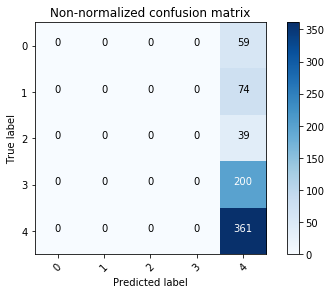

In [17]:
cm_ = confusion_matrix(y_test.argmax(axis = 1), model_final.predict(X_test).argmax(axis=1))
classes_ = ['0','1','2','3','4']
plot_confusion_matrix(cm_, classes = classes_, normalize=False,
                      title='Non-normalized confusion matrix')

In [18]:
print(classification_report(y_test.argmax(axis=1),model_final.predict(X_test).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        59
           1       0.00      0.00      0.00        74
           2       0.00      0.00      0.00        39
           3       0.00      0.00      0.00       200
           4       0.49      1.00      0.66       361

   micro avg       0.49      0.49      0.49       733
   macro avg       0.10      0.20      0.13       733
weighted avg       0.24      0.49      0.33       733



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
#saving the model and its weights

model_json = model_final.to_json()
with open("model_resnet50_1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_final.save_weights("model_resnet50_1_weights.h5")
print("Saved model")

Saved model


## Trying Adam optimizer

Forgot to enter the validation data during the first fitting. After entering the validation data, the validation accuracy remained constant throughout fitting. Going to try Adam optimizer below

In [22]:
img_width, img_height = 224, 224
img_shape = (img_width, img_height, 3)
img_input = Input(shape=img_shape)
base_model = resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=img_shape)

/opt/conda/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [25]:
for layer in base_model.layers[:175]:
    layer.trainable = False

#Adding custom Layers 
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

# creating the final model 
model_final2 = Model(inputs = base_model.input, outputs = predictions)

# compile the model 
model_final2.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=['acc'])

In [26]:
checkpoint = ModelCheckpoint("resnet50_2.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


In [27]:
# Train the model 
model_hist2 = model_final2.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs = 40,
    batch_size = 64,
    callbacks = [checkpoint, early])

Train on 2343 samples, validate on 586 samples
Epoch 1/40
2343/2343 [==============================] - 408s 174ms/step - loss: 5.8480 - acc: 0.6206 - val_loss: 8.1691 - val_acc: 0.4932

Epoch 00001: val_acc improved from -inf to 0.49317, saving model to resnet50_2.h5
Epoch 2/40
2343/2343 [==============================] - 400s 171ms/step - loss: 4.9151 - acc: 0.6944 - val_loss: 8.1691 - val_acc: 0.4932

Epoch 00002: val_acc did not improve from 0.49317
Epoch 3/40
2343/2343 [==============================] - 396s 169ms/step - loss: 5.5478 - acc: 0.6551 - val_loss: 8.1691 - val_acc: 0.4932

Epoch 00003: val_acc did not improve from 0.49317
Epoch 4/40
 128/2343 [>.............................] - ETA: 5:02 - loss: 4.5332 - acc: 0.7188

KeyboardInterrupt: 

## Using to_categorical

The validation accuracy has been stuck at 0.49317 because it's just predicting the most frequently occurring class every time. One answer after some googling suggests that using to_categorical may fix this, as the problem could be originating from an error in comparing against the y matrices.

Although, if the above is true, why is the training accuracy changing? It should be categorical already...

Use weights for balancing the target classes if this doesn't fix the stuck accuracies.

In [78]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val) 
y_test = to_categorical(y_test)

In [29]:
img_width, img_height = 224, 224
img_shape = (img_width, img_height, 3)
img_input = Input(shape=img_shape)
base_model = resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=img_shape)

/opt/conda/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [30]:
for layer in base_model.layers[:175]:
    layer.trainable = False

#Adding custom Layers 
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

# creating the final model 
model_final3 = Model(inputs = base_model.input, outputs = predictions)

# compile the model 
model_final3.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [31]:
checkpoint = ModelCheckpoint("resnet50_3.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [36]:
y_train[:,:,1]

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [37]:
# Train the model 
model_hist3 = model_final3.fit(
    X_train,
    y_train[:,:,1],
    validation_data=(X_val, y_val[:,:,1]),
    epochs = 40,
    batch_size = 64,
    callbacks = [checkpoint, early])

Train on 2343 samples, validate on 586 samples
Epoch 1/40
2343/2343 [==============================] - 392s 167ms/step - loss: 9.8712 - acc: 0.3453 - val_loss: 3.9761 - val_acc: 0.4932

Epoch 00001: val_acc improved from -inf to 0.49317, saving model to resnet50_3.h5
Epoch 2/40
2343/2343 [==============================] - 391s 167ms/step - loss: 4.2093 - acc: 0.7247 - val_loss: 3.4970 - val_acc: 0.4932

Epoch 00002: val_acc did not improve from 0.49317
Epoch 3/40
2343/2343 [==============================] - 389s 166ms/step - loss: 4.0529 - acc: 0.7358 - val_loss: 3.2725 - val_acc: 0.4932

Epoch 00003: val_acc did not improve from 0.49317
Epoch 4/40
2343/2343 [==============================] - 387s 165ms/step - loss: 2.7864 - acc: 0.7187 - val_loss: 1.9380 - val_acc: 0.4932

Epoch 00004: val_acc did not improve from 0.49317
Epoch 5/40
2343/2343 [==============================] - 387s 165ms/step - loss: 0.8128 - acc: 0.7550 - val_loss: 1.4317 - val_acc: 0.4932

Epoch 00005: val_acc did n

KeyboardInterrupt: 

## Adding class weights

It's still predicting only the most commonly occurring class. Use something like the two cells below to add class weights.

In [74]:
from sklearn.utils import class_weight

In [75]:
# classWeight = compute_class_weight('balanced', outputLabels, outputs) 
# classWeight = dict(enumerate(classWeight))
# model.fit(X_train, y_train, batch_size = batch_size, nb_epoch = nb_epochs, show_accuracy = True, verbose = 2, validation_data = (X_test, y_test), class_weight=classWeight)


In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val) 
y_test = to_categorical(y_test)

In [89]:
y_train[:,:,1]

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [91]:
[y.argmax() for y in y_train[:,:,1]]

[4,
 1,
 1,
 4,
 4,
 0,
 2,
 4,
 3,
 4,
 4,
 3,
 3,
 3,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 3,
 4,
 4,
 1,
 4,
 3,
 1,
 3,
 4,
 4,
 3,
 2,
 4,
 4,
 4,
 3,
 4,
 3,
 4,
 4,
 4,
 2,
 2,
 3,
 4,
 3,
 2,
 0,
 3,
 0,
 0,
 4,
 3,
 1,
 0,
 3,
 0,
 4,
 3,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 1,
 1,
 2,
 3,
 4,
 3,
 4,
 3,
 2,
 1,
 3,
 4,
 4,
 3,
 1,
 0,
 4,
 2,
 3,
 3,
 2,
 4,
 3,
 3,
 3,
 3,
 4,
 1,
 4,
 4,
 4,
 4,
 0,
 4,
 3,
 4,
 0,
 4,
 3,
 3,
 1,
 0,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 0,
 1,
 2,
 4,
 3,
 1,
 4,
 3,
 1,
 3,
 4,
 3,
 0,
 4,
 4,
 0,
 4,
 4,
 1,
 4,
 4,
 3,
 4,
 0,
 4,
 0,
 4,
 4,
 4,
 3,
 2,
 4,
 3,
 3,
 2,
 4,
 4,
 2,
 4,
 3,
 2,
 4,
 1,
 4,
 2,
 3,
 4,
 4,
 4,
 2,
 3,
 4,
 4,
 4,
 4,
 4,
 3,
 2,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 4,
 4,
 1,
 4,
 4,
 2,
 4,
 1,
 4,
 4,
 3,
 4,
 4,
 3,
 4,
 1,
 3,
 4,
 1,
 3,
 1,
 3,
 1,
 4,
 4,
 3,
 0,
 4,
 4,
 3,
 4,
 3,
 0,
 3,
 4,
 3,
 3,
 1,
 4,
 4,
 1,
 0,
 4,
 3,
 1,
 1,
 1,
 3,
 4,
 4,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 3,
 4,
 3,
 0,
 3,
 3,
 0,


array([0., 1.], dtype=float32)

In [93]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique([y.argmax() for y in y_train[:,:,1]]),
                                                 [y.argmax() for y in y_train[:,:,1]])

In [94]:
class_weight_dict = dict(enumerate(class_weights))

In [95]:
img_width, img_height = 224, 224
img_shape = (img_width, img_height, 3)
img_input = Input(shape=img_shape)
base_model = resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=img_shape)

/opt/conda/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [100]:
from keras import optimizers

In [102]:
# rerunning this block with new optimizer
adam_opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)

In [103]:
for layer in base_model.layers[:175]:
    layer.trainable = False

#Adding custom Layers 
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

# creating the final model 
model_final3 = Model(inputs = base_model.input, outputs = predictions)

# compile the model 
model_final3.compile(loss='categorical_crossentropy',
              optimizer=adam_opt,
              metrics=['acc'])

In [104]:
checkpoint = ModelCheckpoint("resnet50_3.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [105]:
# Train the model 
model_hist3 = model_final3.fit(
    X_train,
    y_train[:,:,1],
    validation_data=(X_val, y_val[:,:,1]),
    epochs = 40,
    batch_size = 64,
    class_weight=class_weight_dict,
    callbacks = [checkpoint, early])

Train on 2343 samples, validate on 586 samples
Epoch 1/40
2343/2343 [==============================] - 425s 181ms/step - loss: 12.6556 - acc: 0.2783 - val_loss: 11.7173 - val_acc: 0.2730

Epoch 00001: val_acc improved from -inf to 0.27304, saving model to resnet50_3.h5
Epoch 2/40
2343/2343 [==============================] - 397s 169ms/step - loss: 12.8945 - acc: 0.2727 - val_loss: 11.7173 - val_acc: 0.2730

Epoch 00002: val_acc did not improve from 0.27304
Epoch 3/40
2343/2343 [==============================] - 401s 171ms/step - loss: 12.8945 - acc: 0.2727 - val_loss: 11.7173 - val_acc: 0.2730

Epoch 00003: val_acc did not improve from 0.27304
Epoch 4/40
2343/2343 [==============================] - 402s 172ms/step - loss: 12.8945 - acc: 0.2727 - val_loss: 11.7173 - val_acc: 0.2730

Epoch 00004: val_acc did not improve from 0.27304
Epoch 5/40
2343/2343 [==============================] - 406s 173ms/step - loss: 12.8945 - acc: 0.2727 - val_loss: 11.7173 - val_acc: 0.2730

Epoch 00005: val

## Implement Better Data Preprocessing

Taken from [kaggle kernel](https://www.kaggle.com/joorarkesteijn/fast-cropping-preprocessing-and-augmentation)

In [106]:
import cv2
IMAGE_SIZE = 224

In [107]:
def info_image(im):
    # Compute the center (cx, cy) and radius of the eye
    cy = im.shape[0]//2
    midline = im[cy,:]
    midline = np.where(midline>midline.mean()/3)[0]
    if len(midline)>im.shape[1]//2:
        x_start, x_end = np.min(midline), np.max(midline)
    else: # This actually rarely happens p~1/10000
        x_start, x_end = im.shape[1]//10, 9*im.shape[1]//10
    cx = (x_start + x_end)/2
    r = (x_end - x_start)/2
    return cx, cy, r

def resize_image(im, augmentation=True):
    # Crops, resizes and potentially augments the image to IMAGE_SIZE
    cx, cy, r = info_image(im)
    scaling = IMAGE_SIZE/(2*r)
    rotation = 0
    if augmentation:
        scaling *= 1 + 0.3 * (np.random.rand()-0.5)
        rotation = 360 * np.random.rand()
    M = cv2.getRotationMatrix2D((cx,cy), rotation, scaling)
    M[0,2] -= cx - IMAGE_SIZE/2
    M[1,2] -= cy - IMAGE_SIZE/2
    return cv2.warpAffine(im,M,(IMAGE_SIZE,IMAGE_SIZE)) # This is the most important line

def subtract_median_bg_image(im):
    k = np.max(im.shape)//20*2+1
    bg = cv2.medianBlur(im, k)
    return cv2.addWeighted (im, 4, bg, -4, 128)

def subtract_gaussian_bg_image(im):
    k = np.max(im.shape)/10
    bg = cv2.GaussianBlur(im ,(0,0) ,k)
    return cv2.addWeighted (im, 4, bg, -4, 128)

def id_to_image(id_code, resize=True, augmentation=False, subtract_gaussian=False, subtract_median=False):
    path = '../input/train_images/{}.png'.format(id_code)
    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    if resize_image:
        im = resize_image(im, augmentation)
    if subtract_gaussian:
        im = subtract_gaussian_bg_image(im)
    if subtract_median:
        im = subtract_median_bg_image(im)
    return im

## Try if necessary

In [ ]:
# potential option if the above yields bad results
def RESNET_50(classes_number, optim_name='Adam', learning_rate=-1):
    from keras.layers.core import Dense, Dropout, Flatten
    from keras.applications.resnet50 import ResNet50
    from keras.models import Model

    base_model = ResNet50(include_top=True, weights='imagenet')
    x = base_model.layers[-2].output
    del base_model.layers[-1:]
    x = Dense(classes_number, activation='softmax', name='predictions')(x)
    model = Model(input=base_model.input, output=x)

    optim = get_optim('RESNET50', optim_name, learning_rate)
    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
    # print(model.summary())
    return model